# CNN - Convolutional neural networks

- Segmentation: label every pixel with its semantics.
- Convolutions are linear operations; a non linear operation like ReLU is applied after each convolutinal layer.
Multiple convolutional layers are used; they are capturing low level features to high level features as input progresses through the network.
- Stride: the step used to move the kernel over the image. For a 7x7 image, and a 3x3 kernel, if stride=1 then the kernel will move 1 pixel to the right and down each time it is applied. So it will move 5 times horizontally. if stride=2 then it will move 2 pixels to the right and down each time it is applied. So it will move 3 times horizontally. and so on.
- Padding: add zeroes on the borders around the input.
- when convolving a kernel with the input, a dot product is calculated between the flatten view of the kernel and the flatten view of the input resulting in a single number for each cell in the output.
- pooling layers: they reduce the input volume size. The depth of the volume is preserved, e.g. a 4x4x3 would be reduced to a 2x2x3. An implementation is the max pooling that takes the maximum value in each cell of a 2x2 window.
- FX: a final layer fully connected to the volume,
- ResNet skip conections: assuming L1->L2->L3, instead of L3 getting the output of L2 only as input, it gets the addition of the output of both L1 and L2. During backpropagation, the gradient will flow from L3 to L2, but also from L3 to L1.

## Install required packages

In [13]:
!pip install torch albumentations tqdm pandas kagglehub scikit-learn

  Using cached scikit_learn-1.5.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (13 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-macosx_12_0_arm64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Image classification

### Import 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [16]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [18]:
# Train Data
train_data = datasets.MNIST(root='./cnn_data', train=True, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.05MB/s]


Extracting ./cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to ./cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 231kB/s]


Extracting ./cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.17MB/s]


Extracting ./cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.11MB/s]

Extracting ./cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./cnn_data/MNIST/raw



In [20]:
# Test Data
test_data = datasets.MNIST(root='./cnn_data', train=False, download=True, transform=transform)

In [21]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [22]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [23]:
# Create a small batch size for images...let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)
     

In [24]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [25]:
# Grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [26]:
X_Train.shape


torch.Size([1, 28, 28])

In [27]:
x = X_Train.view(1,1,28,28)


In [28]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [29]:
# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [30]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2) # kernal of 2 and stride of 2

In [31]:

x.shape

torch.Size([1, 6, 13, 13])

In [32]:

# Do our second convolutional layer
x = F.relu(conv2(x))

In [33]:
x.shape

torch.Size([1, 16, 11, 11])

In [34]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [35]:

x.shape 

torch.Size([1, 16, 5, 5])

In [36]:
((28-2) / 2 - 2) / 2


5.5

In [37]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [38]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [39]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.
     


In [40]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.16236090660095215
Epoch: 0  Batch: 1200  Loss: 0.1614551544189453
Epoch: 0  Batch: 1800  Loss: 0.5041669607162476
Epoch: 0  Batch: 2400  Loss: 0.10426308214664459
Epoch: 0  Batch: 3000  Loss: 0.007077544927597046
Epoch: 0  Batch: 3600  Loss: 0.3652905821800232
Epoch: 0  Batch: 4200  Loss: 0.0037760832346975803
Epoch: 0  Batch: 4800  Loss: 0.0013758999994024634
Epoch: 0  Batch: 5400  Loss: 0.04505983740091324
Epoch: 0  Batch: 6000  Loss: 0.0005676982691511512
Epoch: 1  Batch: 600  Loss: 0.0040985336527228355
Epoch: 1  Batch: 1200  Loss: 0.26344460248947144
Epoch: 1  Batch: 1800  Loss: 0.0015710301231592894
Epoch: 1  Batch: 2400  Loss: 0.002920893719419837
Epoch: 1  Batch: 3000  Loss: 0.025759723037481308
Epoch: 1  Batch: 3600  Loss: 0.5109620094299316
Epoch: 1  Batch: 4200  Loss: 0.03832785040140152
Epoch: 1  Batch: 4800  Loss: 0.0004107930581085384
Epoch: 1  Batch: 5400  Loss: 0.00042201072210446
Epoch: 1  Batch: 6000  Loss: 0.4828798770904541
Epoch: 2  Ba

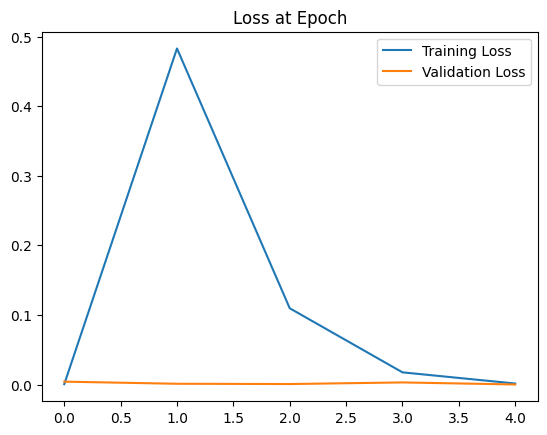

In [41]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

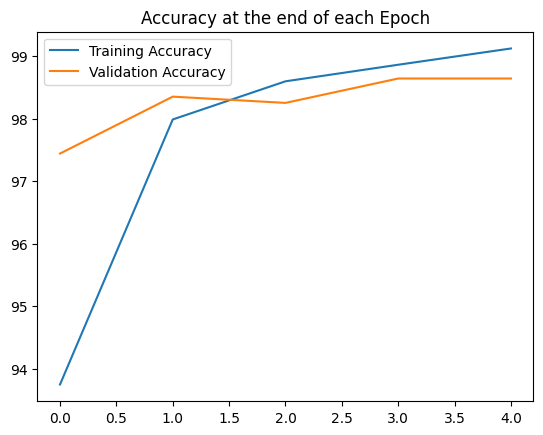

In [42]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [43]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)


In [44]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [45]:
# Did for correct
correct.item()/len(test_data)*100


98.64

In [46]:

# Grab an image
test_data[1978]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [47]:
# Grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [48]:
# Reshape it
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

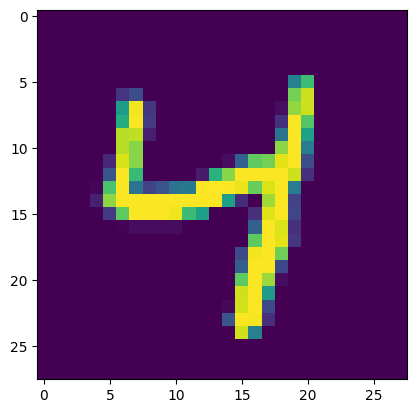

In [49]:
# Show the image
plt.imshow(test_data[1978][0].reshape(28,28))

In [50]:


# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image
     

In [51]:
new_prediction

tensor([[-2.3625e+01, -1.9385e+01, -2.5273e+01, -3.2036e+01, -1.1921e-07,
         -2.0260e+01, -1.7388e+01, -2.0916e+01, -2.0654e+01, -1.6100e+01]])

In [52]:
new_prediction.argmax()


tensor(4)

### Bounding box detection

TBD